Install library

In [ ]:
!pip install scikit-opt

best_x is  [0.   0.05 0.5 ] best_y is [0.25]


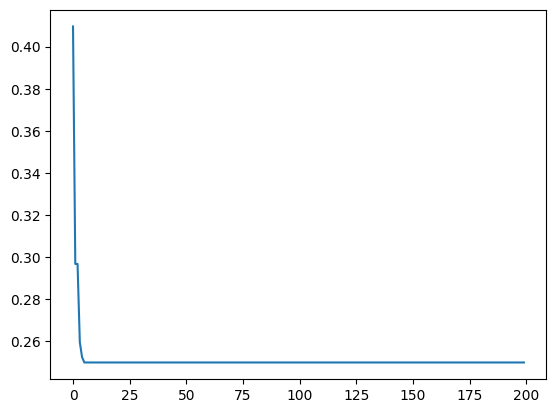

In [ ]:
def demo_func(x):
    x1, x2, x3 = x
    return x1 ** 2 + (x2 - 0.05) ** 2 + x3 ** 2


# %% Do PSO
from sko.PSO import PSO

pso = PSO(func=demo_func, n_dim=3, pop=50, max_iter=200, lb=[0, -1, 0.5], ub=[1, 1, 1], w=0.8, c1=0.5, c2=0.5)
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

# %% Plot the result
import matplotlib.pyplot as plt

plt.plot(pso.gbest_y_hist)
plt.show()

best_x is  [ 9.52463524e-01 -5.37877601e-04] best_y is [2.57993762]


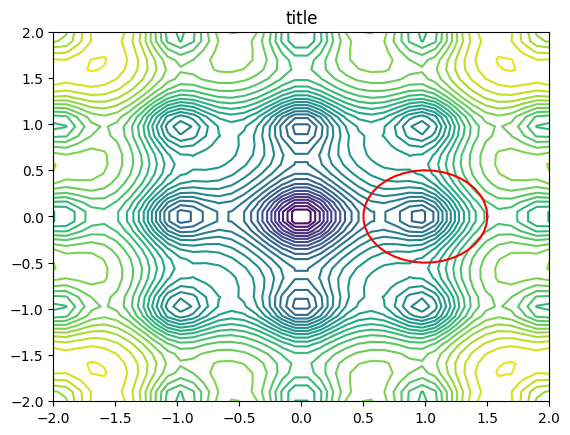

In [ ]:
import numpy as np
from sko.PSO import PSO


def demo_func(x):
    x1, x2 = x
    return -20 * np.exp(-0.2 * np.sqrt(0.5 * (x1 ** 2 + x2 ** 2))) - np.exp(
        0.5 * (np.cos(2 * np.pi * x1) + np.cos(2 * np.pi * x2))) + 20 + np.e


constraint_ueq = (
    lambda x: (x[0] - 1) ** 2 + (x[1] - 0) ** 2 - 0.5 ** 2
    ,
)

max_iter = 50
pso = PSO(func=demo_func, n_dim=2, pop=40, max_iter=max_iter, lb=[-2, -2], ub=[2, 2]
          , constraint_ueq=constraint_ueq)
pso.record_mode = True
pso.run()
print('best_x is ', pso.gbest_x, 'best_y is', pso.gbest_y)

# %% Now Plot the animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

record_value = pso.record_value
X_list, V_list = record_value['X'], record_value['V']

fig, ax = plt.subplots(1, 1)
ax.set_title('title', loc='center')
line = ax.plot([], [], 'b.')

X_grid, Y_grid = np.meshgrid(np.linspace(-2.0, 2.0, 40), np.linspace(-2.0, 2.0, 40))
Z_grid = demo_func((X_grid, Y_grid))
ax.contour(X_grid, Y_grid, Z_grid, 30)

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

t = np.linspace(0, 2 * np.pi, 40)
ax.plot(0.5 * np.cos(t) + 1, 0.5 * np.sin(t), color='r')

plt.ion()
p = plt.show()


def update_scatter(frame):
    i, j = frame // 10, frame % 10
    ax.set_title('iter = ' + str(i))
    X_tmp = X_list[i] + V_list[i] * j / 10.0
    plt.setp(line, 'xdata', X_tmp[:, 0], 'ydata', X_tmp[:, 1])
    return line


ani = FuncAnimation(fig, update_scatter, blit=True, interval=25, frames=max_iter * 10)
plt.show()

ani.save('pso.gif', writer='pillow')

In [ ]:
import numpy as np
import pandas as pd
#from scipy import spatial
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from math import radians, cos, sin, asin, sqrt
from sko.PSO import PSO_TSP

[[ 0.         10.10162453 11.71326462 ... 30.41708417 30.03857492
  31.54841997]
 [10.10162453  0.          2.79500543 ... 20.33278341 20.36793443
  21.72844982]
 [11.71326462  2.79500543  0.         ... 18.95293159 20.14745823
  21.29566929]
 ...
 [30.41708417 20.33278341 18.95293159 ...  0.          8.67507083
   7.60986495]
 [30.03857492 20.36793443 20.14745823 ...  8.67507083  0.
   2.03210355]
 [31.54841997 21.72844982 21.29566929 ...  7.60986495  2.03210355
   0.        ]]
best_distance [134.63049093]


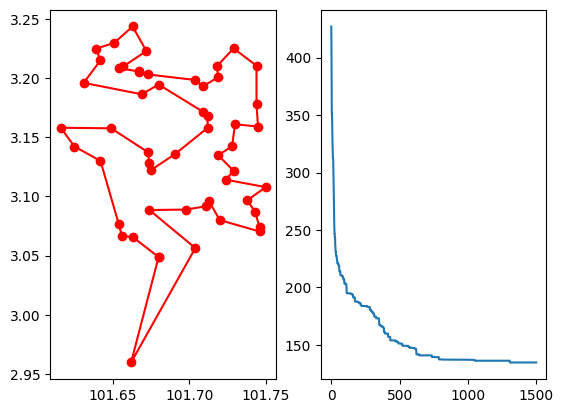

In [ ]:
# read the CSV file into a DataFrame
df = pd.read_csv('STESEN MINYAK KL_P.csv')

# extract the coordinates from the DataFrame
points = df[['lat', 'long']].values

num_customer = 51
num_vehicles = 5
num_points = 1 + num_customer
max_capacity = 16          #use max capacity 16

# define the Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    return R * c

# calculate the distance matrix for the points using the Haversine formula
distance_matrix = np.zeros(shape=(len(points), len(points)), dtype=float)
for i in range(len(points)):
    for j in range(len(points)):
        distance_matrix[i][j] = haversine(points[i][0], points[i][1], points[j][0], points[j][1])

print(distance_matrix)

def cal_total_distance(routine):
    '''The objective function. input routine, return total distance and cal_total_distance(np.arange(num_points))'''
    num_points, = routine.shape
    return distance_matrix[0,routine[0]]\
    + sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])\
    + distance_matrix[routine[-1],0]


def constraint_capacity(routine):
  capacity = 0
  c = 0
  for i in routine:
      if i != 0:
          c += 1
      else:
            capacity = max(capacity, c + 1)
            c = 0
  capacity = max(capacity, c + 1)
  return capacity - max_capacity

# do PSO
num_points = len(points)
pso_tsp = PSO_TSP(func=cal_total_distance, n_dim=num_points, size_pop=1000, max_iter=1500, w=0.8, c1=0.1, c2=0.1)
pso_tsp.has_constraint = True
pso_tsp.constraint_ueq = [constraint_capacity]
best_points, best_distance = pso_tsp.run()

print('best_distance', best_distance)

# plot
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points[best_points_, :]
ax[0].plot(best_points_coordinate[:,1],best_points_coordinate[:,0],'o-r')
ax[1].plot(pso_tsp.gbest_y_hist)
plt.show()
